In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

 In image classification, the binary image classification problem is most often observed where we need to predict the class labels for a given image. So in this section, we are going to build a binary image classifier using a convolutional neural network. The class and dataset that we have chosen is Cat Vs Dog prediction. Where we need to predict the class of the given image as cat or dog and the dataset is taken from the TensorFlow datasets.

The following steps are to be taken to implement the Binary image classification. 

**Step 1: Loading the data**

As we are loading the dataset from the TensorFlow dataset hub, first we need to install it.

In [2]:
!pip install -U tensorflow_datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 12.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: tensorflow_datasets
    Found existing installation: tensorflow-datasets 4.3.0
    Uninstalling tensorflow-datasets-4.3.0:
      Successfully uninstalled tensorflow-datasets-4.3.0


After installing it, now we will load the dataset, keeping the 80% and 20% split for training and validation respectively. 

In [3]:
# loading the dataset
import tensorflow_datasets as tfds
import tensorflow as tf

(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs',
    split = ('train[:80%]', 'train[80%:]'),
    with_info = True,
    as_supervised = True)

2023-02-04 05:44:00.203704: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete1JXZCM/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


2023-02-04 05:44:32.460714: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 05:44:32.556427: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 05:44:32.557195: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 05:44:32.559459: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

**Step 2: Preprocessing the images**

Here in this step we will create a shuffled version of the above images and will resize all images to 224 x 244 x 3 pixels. 

In [4]:
# function to resize images
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image,label

# examples available
num_examples = info.splits['train'].num_examples

# set the batch size and image size
BATCH_SIZE = 32
IMAGE_RES = 224

# Creating the suffled batches 
train_batches = train_examples.cache().shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

Now we will take a look at some samples of images and how it looks. 

2023-02-04 05:44:36.724268: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


<Figure size 720x360 with 0 Axes>

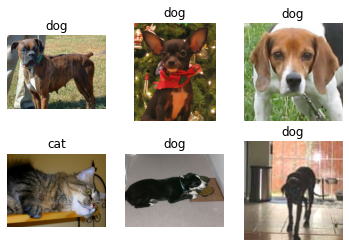

In [5]:
# take look at some samples 
import matplotlib.pyplot as plt
classNames = ['cat', 'dog']
i = 0
plt.figure(figsize=(10,5))
fig, ax = plt.subplots(1, 8)
for image, label in train_examples.take(6):
  plt.subplot(2,3,i+1)
  plt.axis('off')
  plt.title(classNames[label])
  plt.imshow(image)
  i += 1
 
plt.show()

**Step 3: Building the model**

Here in this step, we will be building the convolution-based classifier model. Our model will have 3 convolutional and max-pooling layers and two dense layers. Except for the last layer, the neurons of the rest of the layers fire according to the ReLU activation function. The last layer is a classifier layer; the neurons will be fired according to the soft function. 

In [6]:
# Build the model 
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile and summary
model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 43264)             0

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Now we will compile the model with an optimizer called RMSprop and the loss function as Binary_crossentropy. 

In [7]:
# model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

Let’s obtain the model summary so that we can ensure that the configuration that we are expecting is built. 

So there are a total of 9,494,561 parameters to be trained on all 5 trainable layers. 

**Step 4: Creating train and test data generator**  

Now we will create a generator function which will help us to pass the data batch-wise while training and testing. Although with these generators we can perform certain preprocessing steps such as scaling down the pixel values, augmenting the data, changing the shape of images, etc. 

So below we will create such two sets one for training purposes and the other for validation purposes.

Training of the model

In [8]:
# Training the model
# Note that this may take some time.
history = model.fit(train_batches, epochs=30,validation_data=validation_batches)

Epoch 1/30


2023-02-04 05:44:47.021183: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 19/582 [..............................] - ETA: 28s - loss: 1.5188 - acc: 0.5082

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 52/582 [=>............................] - ETA: 29s - loss: 0.9954 - acc: 0.5457

 62/582 [==>...........................] - ETA: 28s - loss: 0.9434 - acc: 0.5509

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


134/582 [=====>........................] - ETA: 25s - loss: 0.7929 - acc: 0.5879

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


342/582 [================>.............] - ETA: 14s - loss: 0.6746 - acc: 0.6504

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


355/582 [=================>............] - ETA: 13s - loss: 0.6708 - acc: 0.6522

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


365/582 [=================>............] - ETA: 13s - loss: 0.6677 - acc: 0.6536

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


392/582 [===================>..........] - ETA: 11s - loss: 0.6584 - acc: 0.6590

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


398/582 [===================>..........] - ETA: 11s - loss: 0.6564 - acc: 0.6603

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6190 - acc: 0.6836

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 50s 61ms/step - loss: 0.6190 - acc: 0.6836 - val_loss: 0.4880 - val_acc: 0.7676
Epoch 2/30
580/582 [============================>.] - ETA: 0s - loss: 0.4684 - acc: 0.7793

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 21s 37ms/step - loss: 0.4684 - acc: 0.7794 - val_loss: 0.4583 - val_acc: 0.7850
Epoch 3/30
582/582 [==============================] - ETA: 0s - loss: 0.3921 - acc: 0.8228

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 21s 36ms/step - loss: 0.3921 - acc: 0.8228 - val_loss: 0.4179 - val_acc: 0.8138
Epoch 4/30
582/582 [==============================] - ETA: 0s - loss: 0.3243 - acc: 0.8643

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 21s 36ms/step - loss: 0.3243 - acc: 0.8643 - val_loss: 0.4950 - val_acc: 0.8153
Epoch 5/30
580/582 [============================>.] - ETA: 0s - loss: 0.2503 - acc: 0.8980

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 21s 36ms/step - loss: 0.2500 - acc: 0.8981 - val_loss: 0.4951 - val_acc: 0.8057
Epoch 6/30
580/582 [============================>.] - ETA: 0s - loss: 0.1905 - acc: 0.9275

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 21s 36ms/step - loss: 0.1902 - acc: 0.9276 - val_loss: 0.6116 - val_acc: 0.8162
Epoch 7/30
582/582 [==============================] - ETA: 0s - loss: 0.1545 - acc: 0.9441

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 21s 37ms/step - loss: 0.1545 - acc: 0.9441 - val_loss: 0.7666 - val_acc: 0.8113
Epoch 8/30
582/582 [==============================] - ETA: 0s - loss: 0.1248 - acc: 0.9548

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 21s 36ms/step - loss: 0.1248 - acc: 0.9548 - val_loss: 0.6320 - val_acc: 0.7923
Epoch 9/30
580/582 [============================>.] - ETA: 0s - loss: 0.1135 - acc: 0.9623

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 21s 35ms/step - loss: 0.1134 - acc: 0.9623 - val_loss: 0.6891 - val_acc: 0.7560
Epoch 10/30
582/582 [==============================] - ETA: 0s - loss: 0.0984 - acc: 0.9670

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 21s 36ms/step - loss: 0.0984 - acc: 0.9670 - val_loss: 1.5842 - val_acc: 0.8166
Epoch 11/30
581/582 [============================>.] - ETA: 0s - loss: 0.0996 - acc: 0.9692

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 21s 36ms/step - loss: 0.1005 - acc: 0.9690 - val_loss: 0.6952 - val_acc: 0.7883
Epoch 12/30
580/582 [============================>.] - ETA: 0s - loss: 0.1186 - acc: 0.9700

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 21s 36ms/step - loss: 0.1186 - acc: 0.9700 - val_loss: 1.7610 - val_acc: 0.7646
Epoch 13/30
581/582 [============================>.] - ETA: 0s - loss: 0.1338 - acc: 0.9641

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 21s 35ms/step - loss: 0.1337 - acc: 0.9642 - val_loss: 1.2514 - val_acc: 0.8052
Epoch 14/30
582/582 [==============================] - ETA: 0s - loss: 0.1224 - acc: 0.9646

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 21s 35ms/step - loss: 0.1224 - acc: 0.9646 - val_loss: 1.6360 - val_acc: 0.8091
Epoch 15/30
582/582 [==============================] - ETA: 0s - loss: 0.1267 - acc: 0.9666

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 21s 37ms/step - loss: 0.1267 - acc: 0.9666 - val_loss: 1.0509 - val_acc: 0.7807
Epoch 16/30
582/582 [==============================] - ETA: 0s - loss: 0.1464 - acc: 0.9662

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 21s 37ms/step - loss: 0.1464 - acc: 0.9662 - val_loss: 1.1285 - val_acc: 0.7889
Epoch 17/30
581/582 [============================>.] - ETA: 0s - loss: 0.1504 - acc: 0.9630

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 20s 35ms/step - loss: 0.1503 - acc: 0.9631 - val_loss: 1.6457 - val_acc: 0.7956
Epoch 18/30
580/582 [============================>.] - ETA: 0s - loss: 0.1425 - acc: 0.9686

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 22s 37ms/step - loss: 0.1421 - acc: 0.9687 - val_loss: 1.8182 - val_acc: 0.8149
Epoch 19/30
580/582 [============================>.] - ETA: 0s - loss: 0.1458 - acc: 0.9663

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 22s 37ms/step - loss: 0.1457 - acc: 0.9664 - val_loss: 3.3083 - val_acc: 0.8033
Epoch 20/30
582/582 [==============================] - ETA: 0s - loss: 0.1756 - acc: 0.9585

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 21s 36ms/step - loss: 0.1756 - acc: 0.9585 - val_loss: 1.3195 - val_acc: 0.8044
Epoch 21/30
580/582 [============================>.] - ETA: 0s - loss: 0.1582 - acc: 0.9642

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 22s 37ms/step - loss: 0.1578 - acc: 0.9643 - val_loss: 1.6164 - val_acc: 0.8029
Epoch 22/30
580/582 [============================>.] - ETA: 0s - loss: 0.1576 - acc: 0.9649

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 21s 36ms/step - loss: 0.1574 - acc: 0.9649 - val_loss: 1.7038 - val_acc: 0.7917
Epoch 23/30
580/582 [============================>.] - ETA: 0s - loss: 0.1703 - acc: 0.9630

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 22s 37ms/step - loss: 0.1699 - acc: 0.9630 - val_loss: 1.9131 - val_acc: 0.8014
Epoch 24/30
582/582 [==============================] - ETA: 0s - loss: 0.1607 - acc: 0.9691

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 21s 36ms/step - loss: 0.1607 - acc: 0.9691 - val_loss: 2.0073 - val_acc: 0.8085
Epoch 25/30
581/582 [============================>.] - ETA: 0s - loss: 0.1778 - acc: 0.9695

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 21s 36ms/step - loss: 0.1776 - acc: 0.9695 - val_loss: 2.4712 - val_acc: 0.7954
Epoch 26/30
582/582 [==============================] - ETA: 0s - loss: 0.1604 - acc: 0.9690

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 22s 37ms/step - loss: 0.1604 - acc: 0.9690 - val_loss: 2.1634 - val_acc: 0.8009
Epoch 27/30
581/582 [============================>.] - ETA: 0s - loss: 0.1746 - acc: 0.9661

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 21s 36ms/step - loss: 0.1745 - acc: 0.9661 - val_loss: 1.2857 - val_acc: 0.7835
Epoch 28/30
582/582 [==============================] - ETA: 0s - loss: 0.1700 - acc: 0.9661

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 22s 37ms/step - loss: 0.1700 - acc: 0.9661 - val_loss: 1.8719 - val_acc: 0.7790
Epoch 29/30
582/582 [==============================] - ETA: 0s - loss: 0.1621 - acc: 0.9677

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 21s 36ms/step - loss: 0.1621 - acc: 0.9677 - val_loss: 2.5200 - val_acc: 0.7771
Epoch 30/30
582/582 [==============================] - ETA: 0s - loss: 0.1603 - acc: 0.9631

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 20s 35ms/step - loss: 0.1603 - acc: 0.9631 - val_loss: 1.9393 - val_acc: 0.7659


plot results after training

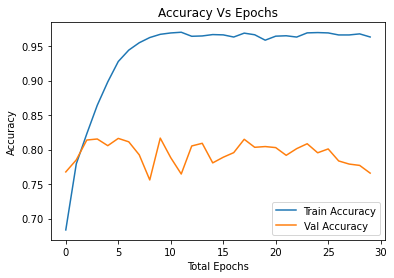

In [9]:
plt.plot(history.history['acc'], label = 'Train Accuracy')
plt.plot(history.history['val_acc'], label = 'Val Accuracy')
plt.xlabel('Total Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Vs Epochs')
plt.legend()

plotting the training and validation loss

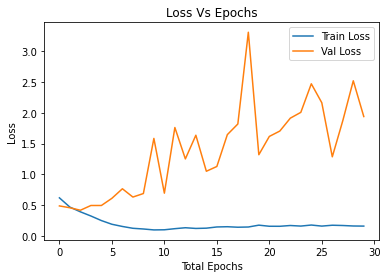

In [10]:
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.xlabel('Total Epochs')
plt.ylabel('Loss')
plt.title('Loss Vs Epochs')
plt.legend()

predicting a random using above fitted model: first lets import necessary libraries

In [11]:
import requests 
import numpy as np
import cv2

In [12]:
def pred(url):
  req = requests.get(url)
  arr = np.asarray(bytearray(req.content), dtype=np.uint8)
  img = cv2.imdecode(arr, -1) 
  plt.imshow(img)
  plt.axis('off')
  test = cv2.resize(img,(224,224))
  result = model.predict(test.reshape(1,224, 224, 3)/255.)
  return "The given image is of {}".format('cat' if result.round()==1 else 'dog')

'The given image is of dog'

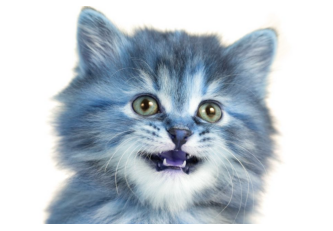

In [15]:
pred('https://moderncat.com/wp-content/uploads/2014/03/tortoiseshell-kitten-closeup-p-46771525-940x640.jpg')

LLLLLL

'The given image is of dog'

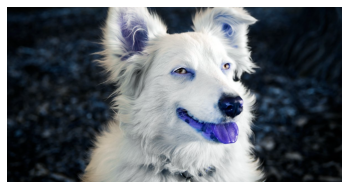

In [14]:
pred('https://api.time.com/wp-content/uploads/2017/04/world-of-dogs-07.jpg?quality=85&w=1200&h=628&crop=1')

'The given image is of dog'

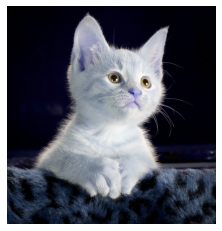

In [16]:
pred('https://images.pexels.com/photos/45201/kitty-cat-kitten-pet-45201.jpeg')